In [177]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [178]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
gs=pd.read_csv("gender_submission.csv")

I like to look at the _tail_, rather than the _head_, of a df, since it gives you the number of instances as well as a peak at the data

# Initial analysis

In [179]:
train.tail(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [180]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [181]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The train data set has missing values. In particular, the cabin data is particularly sparse.

In [182]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

So _Age_, _Cabin_, and _Embarked_ features have missing instances. How many rows have missing data?

In [183]:
train.shape[0]-train.dropna().shape[0]

708

We want to model survival or fatality by building a binary classifier. How many people died on the titanic in our train set?

In [184]:
print("Died {} ({:.0f}%)\nSurvived: {} ({:.0f}%)".format(len(train[train["Survived"]==0]),
                                                (len(train[train["Survived"]==0])/len(train))*100,
                                                len(train[train["Survived"]==1]),
                                               (len(train[train["Survived"]==1])/len(train))*100))


Died 549 (62%)
Survived: 342 (38%)


Our train set is biased by 2:1 for deaths vs survival. Lets do a pairwise plot using only rows with full instances with no NAs, and only numeric values

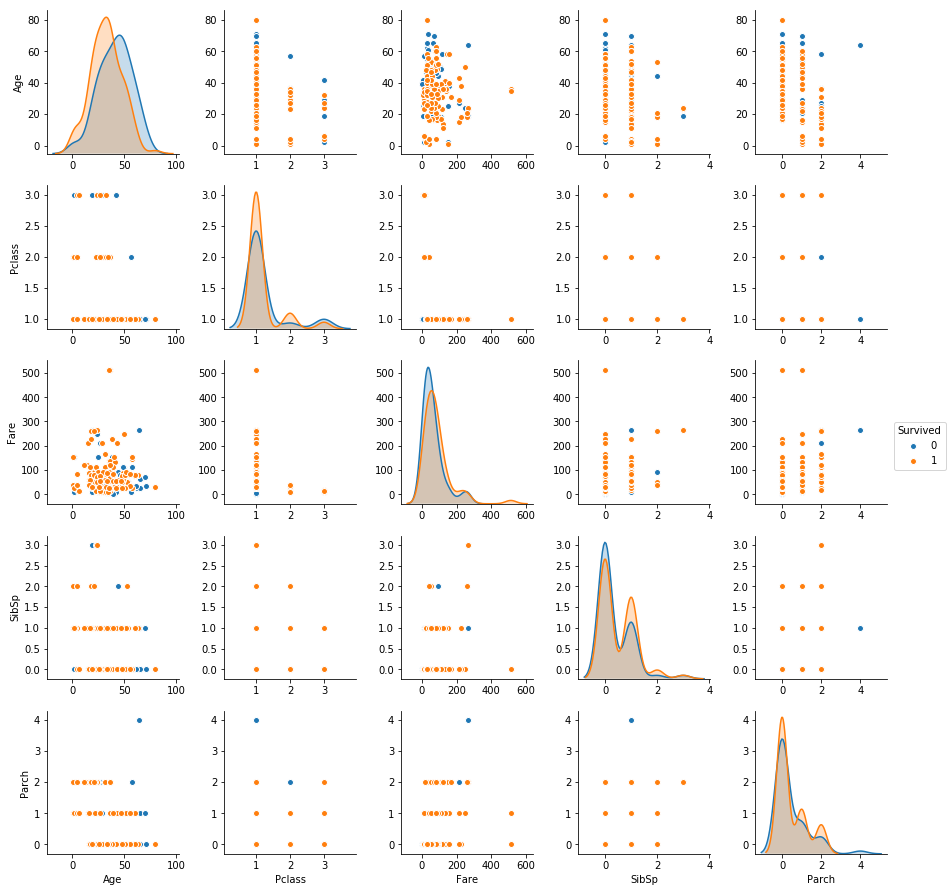

In [185]:
sns.pairplot(train.dropna(),hue="Survived",vars=["Age","Pclass","Fare","SibSp","Parch"],diag_kind="kde",diag_kws=dict(shade=True))

## Gender

In [186]:
def bar_by_feat(dataframe,feat1,feat2):
    """Plot two feature 1 against feature 2 of the data frame"""
    positive=dataframe[dataframe[feat1]==1][feat2].value_counts()
    negative=dataframe[dataframe[feat1]==0][feat2].value_counts()
    newdf=pd.DataFrame([positive,negative])
    newdf.index=["positive","negative"]
    newdf.plot(kind='bar',stacked=True,figsize=(4,2),alpha=0.6,width=0.2,fontsize=12)
    

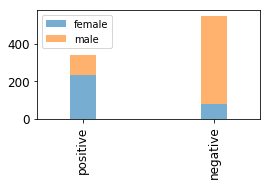

In [187]:
bar_by_feat(train,"Survived","Sex")

It is evident that you are more likely to survive if female.

## Age

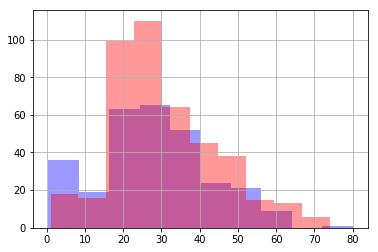

In [188]:
train.loc[train["Survived"]==1,"Age"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Age"].hist(alpha=0.4,color="red")

It appears being in your mid 20s is not good for your survival chances!

## Fare

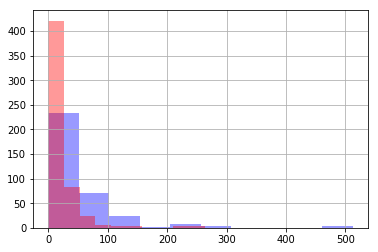

In [189]:
train.loc[train["Survived"]==1,"Fare"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Fare"].hist(alpha=0.4,color="red")

Clearly the price you pay greatly influences your chance of surivial. At the extreme high prices, you survive.

The fares are far from normally distributed. I may need to play with that later

# Pclass

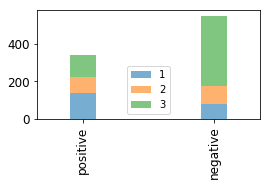

In [190]:
bar_by_feat(train,"Survived","Pclass")

Cearly most passengers are in 3rd class and most will die. 2/3 first class passengers will survive

In [191]:
for pclass in train["Pclass"].unique():
    died=train.loc[(train["Pclass"] ==pclass) & (train["Survived"] == 0), "Pclass"].shape[0]
    diedpcnt=(died/train.loc[train["Pclass"]==pclass].shape[0])*100
    survived=train.loc[(train["Pclass"] ==pclass) & (train["Survived"] == 1), "Pclass"].shape[0]
    survivedpcnt=(survived/train.loc[train["Pclass"]==pclass].shape[0])*100
    print("Class {}: {} ({:.0f}%) Survived, {} ({:.0f}%) Died".format(pclass,survived,survivedpcnt,died,diedpcnt))

Class 3: 119 (24%) Survived, 372 (76%) Died
Class 1: 136 (63%) Survived, 80 (37%) Died
Class 2: 87 (47%) Survived, 97 (53%) Died


## SibSp

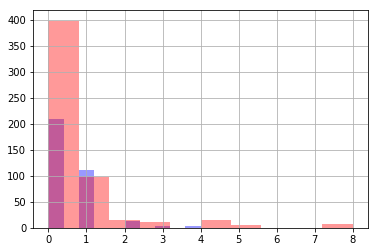

In [192]:
train.loc[train["Survived"]==1,"SibSp"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"SibSp"].hist(alpha=0.4,color="red")

## Parch

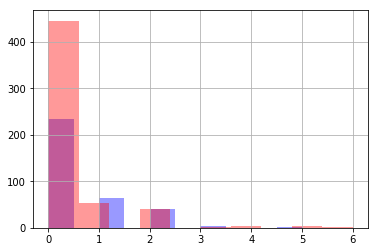

In [193]:
train.loc[train["Survived"]==1,"Parch"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Parch"].hist(alpha=0.4,color="red")

# Conversion of catagorical data

In order to build a classifier, we are going to have to convert our catagorical features (sex,ticket,embarked) to vectors.

In [194]:
for i in train.select_dtypes(include=['object']).columns:
    print("{}: {} values, {} unique".format(i,len(train[i]),len(train[i].unique())))

Name: 891 values, 891 unique
Sex: 891 values, 2 unique
Ticket: 891 values, 681 unique
Cabin: 891 values, 148 unique
Embarked: 891 values, 4 unique


The name, ticket and cabin variables have many values. For my first model, I will exclude these. I shall only include "Sex" and "Embarked" of the catagorical values in the model. For this I will need to convert them to floating point values

In [195]:
train["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [196]:
train["Sex"].unique()

array(['male', 'female'], dtype=object)

In [197]:
train["Sex"]=train["Sex"].replace(to_replace='male',value=0)
train["Sex"]=train["Sex"].replace(to_replace='female',value=1)
train["Embarked"]=train["Embarked"].replace(to_replace='S',value=0)
train["Embarked"]=train["Embarked"].replace(to_replace='C',value=1)
train["Embarked"]=train["Embarked"].replace(to_replace='Q',value=2)

I am going to test a few different algorithms, using a subset of the data. I expect these to be underfitted, since I have done litte feature engineering up to this point. Iniitally, I will test a few classifiers using _scikitlearn_ to get a baseline accuracy. I will then do some feature engineering to improve the models. 

# Baseline models

In [198]:
features=["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]

In [199]:
X=train[features].dropna().drop("Survived",axis=1)
y=train[features].dropna()["Survived"]
print(len(X),len(y))
print(y.mean())

712 712
0.404494382022


So 40% of our input data for the first model have value==1 (ie, they survived). This is fair reflection of the original set, which has a 38% survival rate. For the current train set, if we predict 1 for every instance, we would be correct 40% of the time.

I am going to further split our train data set into a train and test set, so we can test our model properly, since the _test_ set provided by Kaggle does not have an answer we can check so we cannot validate our model against it

In [200]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())

534
178
0.397003745318
0.426966292135


In [201]:
scores={}

### Gaussian Naive Bayes

The first method I will trial is Gaussian Naive Bayes

In [202]:
from sklearn.naive_bayes import GaussianNB

In [203]:
gnb = GaussianNB()
gnb=gnb.fit(X_train,y_train)
gnb.score(X_train,y_train)
print(gnb.score(X_train,y_train))

0.784644194757


So GNB is accurate on 78.5% of the training data. What about the test set?

In [204]:
print("GNB accurately predicts {:.2f}% of the test set".format(gnb.score(X_test,y_test)*100))
scores["GNB"]=gnb.score(X_test,y_test)*100

GNB accurately predicts 78.09% of the test set


In [205]:
gnb_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],(y_test != gnb_pred).sum()))

Number of mislabeled points out of a total 178 points : 39


In [206]:
from sklearn.metrics import confusion_matrix

In [207]:
tn, fp, fn, tp = confusion_matrix(y_test,gnb_pred).ravel()
(tn, fp, fn, tp)

(83, 19, 20, 56)

In [208]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 83
Incorrect Survival: 19
Incorrect Death: 20
Correct Surivival: 56


### Logistic Regression

In [209]:
from sklearn.linear_model import LogisticRegression 

In [210]:
lrmodel=LogisticRegression()
lrmodel=lrmodel.fit(X_train,y_train)
lrmodel.score(X_train,y_train)


0.797752808988764

In [211]:
lrmodel.score(X_test,y_test)
scores["LR"]=lrmodel.score(X_test,y_test)*100

In [212]:
lr_pred = lrmodel.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,lr_pred).ravel()
(tn, fp, fn, tp)

(83, 19, 19, 57)

In [213]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 83
Incorrect Survival: 19
Incorrect Death: 19
Correct Surivival: 57


### Decision Tree

In [214]:
from sklearn.tree import DecisionTreeClassifier

In [215]:
dt=DecisionTreeClassifier()
dt=dt.fit(X_train,y_train)
dt.score(X_train,y_train)


0.99250936329588013

In [216]:
dt.score(X_test,y_test)
scores["DT"]=dt.score(X_test,y_test)*100

In [217]:
dt_pred = dt.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,dt_pred).ravel()
(tn, fp, fn, tp)

(84, 18, 18, 58)

In [218]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 84
Incorrect Survival: 18
Incorrect Death: 18
Correct Surivival: 58


In [219]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#### Visualise the decision tree

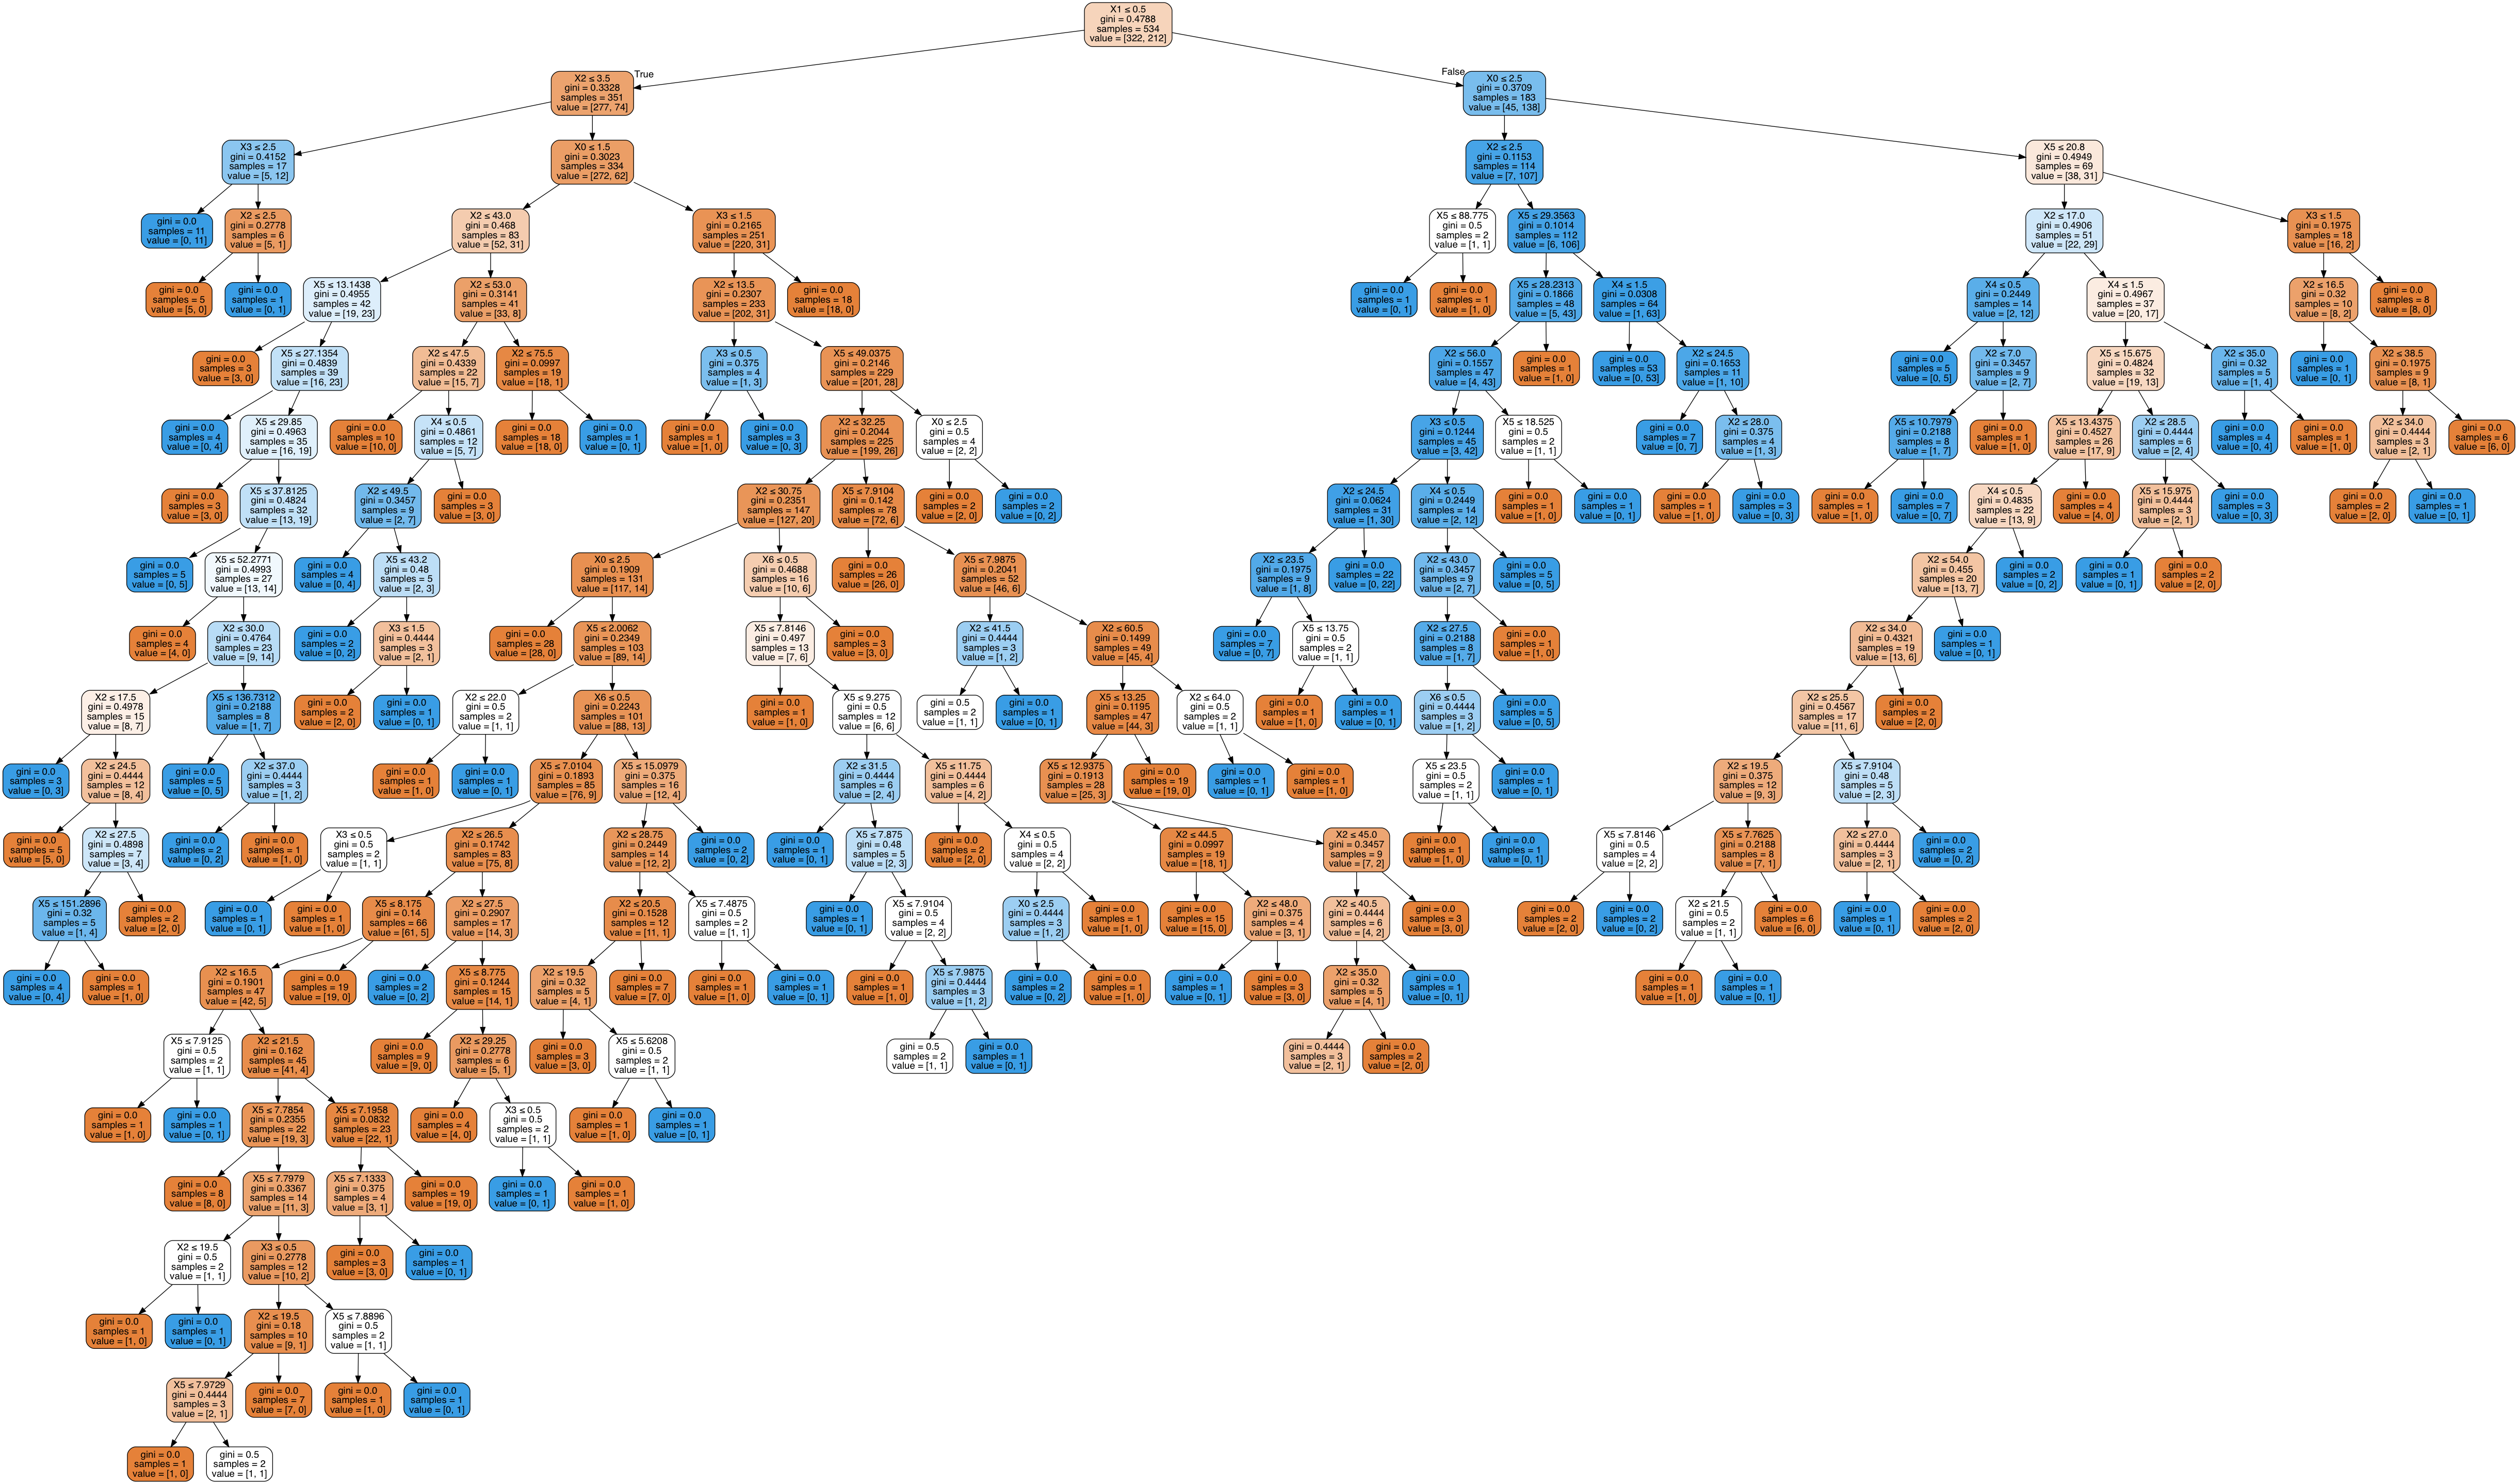

In [220]:
# thanks to https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [221]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

The first branch in the tree is x1 less than/equal to 0.5. ie male/female. Next are Pclass and age

### Gradient Boosting

Lets see if gradient boosting improves upon the lone decision tree

In [222]:
from  sklearn.ensemble import GradientBoostingClassifier

In [223]:
gb=GradientBoostingClassifier()
gb=gb.fit(X_train,y_train)
gb.score(X_train,y_train)

0.9157303370786517

In [224]:
gb.score(X_test,y_test)
scores["gb"]=gb.score(X_test,y_test)*100

# Summary of baseline models

In [225]:
scores

{'DT': 78.089887640449433,
 'GNB': 78.089887640449433,
 'LR': 78.651685393258433,
 'gb': 82.022471910112358}

# Engineering

In [226]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.6+ KB


In [227]:
print("{} in the set, {} features in the training set, {} in the test set. {} features excluded".format(train.shape[0],y_train.shape[0],y_test.shape[0],(train.shape[0]-(y_train.shape[0]+y_test.shape[0]))))

891 in the set, 534 features in the training set, 178 in the test set. 179 features excluded


## Adding an _accompanied_ feature

The first feature I want to work on is whether someone is travelling alone or not. It seems to me that a child's survival chance will be improved if they are travelling with an adult, and vice versa, since we know history (and the movie _Titanic_ ;)) that women and children were evacuated on life boats.

In [228]:
train["Accompanied"]=train["Parch"] + train["SibSp"]

In [229]:
train['Accompanied'].loc[train['Accompanied'] > 0] = 1
train['Accompanied'].loc[train['Accompanied'] == 0] = 0


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [230]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Accompanied
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1.0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0.0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0.0,0


In [231]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Accompanied
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.362205,0.397306
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.636157,0.489615
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,1.000000


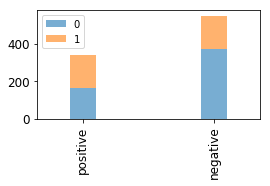

In [232]:
bar_by_feat(train,"Survived","Accompanied")

## Filling in missing ages

In [233]:
print("There are {} missing ages.".format(train[train["Age"].isnull()].shape[0]))

There are 177 missing ages.


There are different ways to complete the ages. The easist is probably by just using the median age. However, this brute force approach is not particularly elegant and risks us losing a lot of resultion. Is there a more nuanced approach? For instance, we can further distill by using medians of the age if they are male or female, ticket class, fare price etc

In [234]:
train["Age"].median()

28.0

From our train subset, the decision tree classifier has gender as the first branch. So lets use that as a starting point for assigning the unknown ages

In [235]:
for s in train["Sex"].unique():
    print("Sex: {}: Median Age: {}".format(s,train.loc[train["Sex"]==s,"Age"].median()))

Sex: 0: Median Age: 29.0
Sex: 1: Median Age: 27.0


Lets look at how we can use the Pclass to further classify the age. Pclass is good becasue there are only 3 values

In [236]:
for pclass in train["Pclass"].unique():
    print("Class: {} Median Age: {}".format(pclass,train.loc[train["Pclass"]==pclass,"Age"].median()))

Class: 3 Median Age: 24.0
Class: 1 Median Age: 37.0
Class: 2 Median Age: 29.0


We can already see that people in class 1 are older than in class 3, which we can use to our advantage when assigning the new ages

How about we use a model to predict the unknown ages?

In [347]:
features.append("Accompanied")

In [351]:
features

['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Accompanied']

In [352]:
X=train[features].dropna().drop("Age",axis=1)
y=train[features].dropna()["Age"]
print(len(X),len(y))
print(y.mean())


712 712
29.6420926966


In [297]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(X_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())
np.std(y_train)

534
534
178
30.0355805243
28.4616292135


14.862392499369461

In [292]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [299]:
Age_regr = LinearRegression()
Age_regr = Age_regr.fit(X,y)
Age_regr.score(X,y)

0.27067145478761079

In [301]:
age_pred=Age_regr.predict(X_train)

In [270]:
# The coefficients
print('Coefficients: \n', Age_regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, age_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, age_pred))


Coefficients: 
 [-7.73190476 -8.06745637  0.81809736 -4.53484695 -0.35113795 -0.01209603
 -0.54220854]
Mean squared error: 158.03
Variance score: 0.28


In [338]:
df=pd.DataFrame({"pred": age_pred,"actual":y_train})

In [346]:
meds=np.zeros(len(y_train))
meds=meds+29
Age_regr.score(X_train,meds)

ValueError: Found input variables with inconsistent numbers of samples: [534, 712]

In [342]:
df

,actual,pred
453,49.00,32.403289
812,35.00,37.272892
449,52.00,38.228209
146,27.00,22.364565
880,25.00,28.736335
311,18.00,25.366422
122,32.50,32.033391
663,36.00,29.215869
627,21.00,37.814740
302,19.00,29.328290


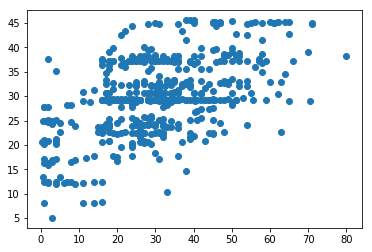

In [322]:
plt.scatter(y_train,age_pred)